# K-Means Clustering

This notebook is based on Exercise 7 of the Machine Learning Course by Andrew Ng on Coursera ([course link](https://www.coursera.org/learn/machine-learning)).

In this exercise we'll implement K-means clustering and use it to compress an image.  We'll start with a simple 2D data set to see how K-means works, then we'll apply it to image compression.  We'll also experiment with principal component analysis and see how it can be used to find a low-dimensional representation of images of faces.

## K-means clustering

To start out we're going to implement and apply K-means to a simple 2-dimensional data set to gain some intuition about how it works.  K-means is an iterative, unsupervised clustering algorithm that groups similar instances together into clusters.  The algorithm starts by guessing the initial centroids for each cluster, and then repeatedly assigns instances to the nearest cluster and re-computes the centroid of that cluster.  The first piece that we're going to implement is a function that finds the closest centroid for each instance in the data.

### Find Closest Centroid

In the first step, we start with K centroids for each of the K clusters and assign all points to their nearest clusters. This procedure is implement in the `find_closest_centroids` method.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

In [39]:
# X : data, centroid : K-size array
def find_closest_centroids(X, centroids):
    m = X.shape[0]
    k = centroids.shape[0]
    idx = np.zeros(m) # stores the cluster id for each data point
    
    for i in range(m):
        min_dist = 1000000  # some upper bound on the distance
        for j in range(k):
            dist = np.sum((X[i,:] - centroids[j,:]) ** 2)
            if dist < min_dist:
                min_dist = dist
                idx[i] = j
    
    return idx

### Find Cluster Centroid

In the second step, we revise our centroid estimates given the cluster assignments for all points. Thus, for a particular cluster $C_l$, we find the centroid $\mu_l$ as:
$$ \mu_l = \frac{1}{|C_l|}\sum_{i\in C_l} x^{(i)} $$

This procedure is implemented as the method `compute_centroids`.

In [40]:
def compute_centroids(X, idx, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    
    for i in range(k):
        indices = np.where(idx == i)
        centroids[i,:] = (np.sum(X[indices,:], axis=1) / len(indices[0])).ravel()
    
    return centroids

Finally, we run repeat the aformentioned steps in sequence for `max_iter` number of iterations to compute the cluster centers.

In [41]:
# X : data, initial_centroids, max_iters : max number of iterations
def run_k_means(X, initial_centroids, max_iters):
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids
    
    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, k)
    
    return idx, centroids

One step we skipped over is a process for initializing the centroids.  This can affect the convergence of the algorithm.  We can create a function that selects random examples and uses them as the initial centroids.

In [42]:
# X : data, k : number of clusters
def init_centroids(X, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    idx = np.random.randint(0, m, k)
    
    for i in range(k):
        centroids[i,:] = X[idx[i],:]
    
    return centroids

Our next task is to apply K-means to image compression.  The intuition here is that we can use clustering to find a small number of colors that are most representative of the image, and map the original 24-bit colors to a lower-dimensional color space using the cluster assignments.  Here's the image we're going to compress.

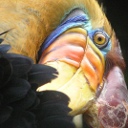

In [44]:
from IPython.display import Image
Image(filename='bird_small.png')

The raw pixel data has been pre-loaded for us so let's pull it in.

In [46]:
image_data = loadmat('bird_small.mat')
image_data

{'A': array([[[219, 180, 103],
         [230, 185, 116],
         [226, 186, 110],
         ..., 
         [ 14,  15,  13],
         [ 13,  15,  12],
         [ 12,  14,  12]],
 
        [[230, 193, 119],
         [224, 192, 120],
         [226, 192, 124],
         ..., 
         [ 16,  16,  13],
         [ 14,  15,  10],
         [ 11,  14,   9]],
 
        [[228, 191, 123],
         [228, 191, 121],
         [220, 185, 118],
         ..., 
         [ 14,  16,  13],
         [ 13,  13,  11],
         [ 11,  15,  10]],
 
        ..., 
        [[ 15,  18,  16],
         [ 18,  21,  18],
         [ 18,  19,  16],
         ..., 
         [ 81,  45,  45],
         [ 70,  43,  35],
         [ 72,  51,  43]],
 
        [[ 16,  17,  17],
         [ 17,  18,  19],
         [ 20,  19,  20],
         ..., 
         [ 80,  38,  40],
         [ 68,  39,  40],
         [ 59,  43,  42]],
 
        [[ 15,  19,  19],
         [ 20,  20,  18],
         [ 18,  19,  17],
         ..., 
         [ 65,  43

In [47]:
A = image_data['A']
A.shape

(128, 128, 3)

Now we need to apply some pre-processing to the data and feed it into the K-means algorithm.

In [48]:
# normalize value ranges between 0, 1
A = A / 255.

# reshape the array
X = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2])) # each color channel is linearized
X.shape

(16384, 3)

This means that you have 16384 3D data points. Now, we find $K=16$ clusters to map each data value to one of the 16 cluster centroid values.

In [49]:
# randomly initialize the centroids
initial_centroids = init_centroids(X, 16)

# run the algorithm
idx, centroids = run_k_means(X, initial_centroids, 10)

# get the closest centroids one last time
idx = find_closest_centroids(X, centroids)

# map each pixel to the centroid value
X_recovered = centroids[idx.astype(int),:]
X_recovered.shape

(16384, 3)

In [50]:
uniques = np.vstack(set(map(tuple, X_recovered)))
print uniques.shape # we have only of 16 unique points now

(16, 3)


In [51]:
# reshape to the original dimensions
X_recovered = np.reshape(X_recovered, (A.shape[0], A.shape[1], A.shape[2]))
X_recovered.shape

(128, 128, 3)

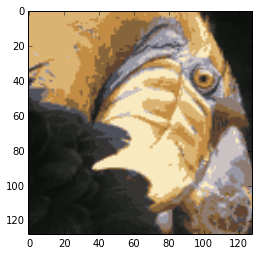

In [52]:
plt.imshow(X_recovered)

Isn't that amazing? All we need now is one of the 16 values at each point in the image to store the image as shown above. You can see that we created some artifacts in the compression but the main features of the image are still there. That's it for K-means.